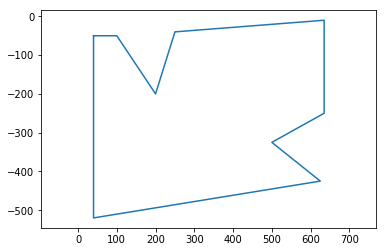

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.axis("equal")
fig_size = [10,10]
plt.rcParams["figure.figsize"] = fig_size

data =np.array([[40, 50],
       [40, 520],
       [625,425],
       [500,325],
       [635,250],
       [635,10],
       [250,40],
       [200,200],
       [100,50],
       [40, 50]])

plt.plot(data[:,0],-data[:,1])
plt.show()


In [2]:
from shapeanalyzer.vectmat import Vector2
from shapeanalyzer.shapes import Point, LineSegment, Ray

def bisector(po, p1, p2):
    v1 = Vector2(p1.x-po.x, p1.y-po.y).normalize()
    v2 = Vector2(p2.x-po.x, p2.y-po.y).normalize()
    bv = v1+v2
    return Ray(po,bv.normalize())

p0 = Point(0,0)
p1 = Point(1,0)
p2 = Point(0,1)
p3 = Point(1,1)
ray1 = bisector(p0,p1,p2)
ray2 = bisector(p2,p0,p3)
print ray1, ray2
rint = ray1.intersection(ray2)
print rint


Ray (Point ( 0.0, 0.0 ), Vector2 (0.71, 0.71)) Ray (Point ( 0.0, 1.0 ), Vector2 (0.71, -0.71))
Point ( 0.5, 0.5 )
